In [26]:
## import packages and modules
import boto3, botocore
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

## fetch file content from s3
s3 = boto3.resource('s3')
bucket = s3.Bucket('danhtran358-data-445-bucket')
bucket_object = bucket.Object('project_cleaned_data.csv')
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Dataset 1
## read file content to data-frame
diabetes = pd.read_csv(file_content_stream)
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,89,66,23,94,28.1,0.167,21,0
1,0,137,40,35,168,43.1,2.288,33,1
2,3,78,50,32,88,31.0,0.248,26,1
3,2,197,70,45,543,30.5,0.158,53,1
4,1,189,60,23,846,30.1,0.398,59,1
...,...,...,...,...,...,...,...,...,...
387,0,181,88,44,510,43.3,0.222,26,1
388,1,128,88,39,110,36.5,1.057,37,1
389,2,88,58,26,16,28.4,0.766,22,0
390,10,101,76,48,180,32.9,0.171,63,0


In [27]:
## defining input and target variables
X = diabetes.drop(columns = ['Outcome'])
Y = diabetes['Outcome']

In [28]:
## function to write write data_frame to csv file object in S3 bucket
def write_data_to_s3(file_name, data_frame):
    ## file object in s3 bucket
    data_file = bucket.Object(file_name)
    
    ## add content from the lists of recall scores
    content = data_frame.to_csv(index=False)

    ## store as new csv file
    data_file.put(Body = content)
    

## function to read logistic model data stored in s3 csv to dataframe
def read_data_from_s3(file_name):
    try:
        ## file object in s3 bucket
        data_file = bucket.Object(file_name)
        
        data_file.load()
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            ## file does not exist yet, create new file
            lasso_coef = list()
            results = pd.DataFrame(lasso_coef, columns = X.columns)
            results.at[0, 'total_loops'] = 0
                    
            write_data_to_s3(file_name, results)
            
            ## return the dataframe from newly created file
            return pd.read_csv(data_file.get().get('Body'))
    else:
        ## return the dataframe already stored
        return pd.read_csv(data_file.get().get('Body'))

In [29]:
## List to store coefficients
lasso_coef = list()

## read from s3 bucket lasso data already saved
file_name = 'project_lasso_coef.csv'
results = read_data_from_s3(file_name)

## only loop if data save is not enough for 100 loops
for loop_number in range(int(results.at[0, 'total_loops']), 1000):
    
    # Splitting the data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    
    ## Estimate lambda using cv
    lasso_cv = LassoCV(normalize = True, cv = 20).fit(X_train, Y_train)
    
    ## Building LASSO model
    lasso_md = Lasso(alpha = lasso_cv.alpha_, normalize = True).fit(X_train, Y_train)
    
    ## Prepare data before writing to s3 bucket
    lasso_coef.append(lasso_md.coef_)
    lasso_coef_df = pd.DataFrame(lasso_coef, columns = X.columns)
    lasso_coef_df['total_loops'] = loop_number + 1
    
    ## Write result to s3 bucket
    write_data_to_s3(file_name, lasso_coef_df)

## Read data from bucket and display
lasso_coef_df = read_data_from_s3(file_name)
lasso_coef_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,total_loops
0,0.008880,0.005662,0.000000,0.002969,-0.0,0.007960,0.121045,0.005041,1000
1,0.014686,0.005755,0.000000,0.002318,0.0,0.008935,0.170847,0.006046,1000
2,0.005665,0.005004,0.000000,0.000927,-0.0,0.008257,0.152042,0.008320,1000
3,0.010149,0.005789,0.000398,0.000572,-0.0,0.009409,0.125910,0.005683,1000
4,0.019601,0.005939,-0.000000,0.002652,-0.0,0.008242,0.131973,0.003155,1000


In [30]:
## get the count of 0 in each column
print((lasso_coef_df == 0).sum())

Pregnancies                  43
Glucose                       0
BloodPressure               639
SkinThickness               126
Insulin                     789
BMI                           0
DiabetesPedigreeFunction      1
Age                           1
total_loops                   0
dtype: int64


In [31]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1,89,66,23,94,28.1,0.167,21
1,0,137,40,35,168,43.1,2.288,33
2,3,78,50,32,88,31.0,0.248,26
3,2,197,70,45,543,30.5,0.158,53
4,1,189,60,23,846,30.1,0.398,59


In [32]:
## Dataset 2
## only choose columns that have less than 500 times having 0 coefficient
X_lasso = diabetes[['Pregnancies', 'Glucose', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
X_lasso

,Pregnancies,Glucose,SkinThickness,BMI,DiabetesPedigreeFunction,Age
0,1,89,23,28.1,0.167,21
1,0,137,35,43.1,2.288,33
2,3,78,32,31.0,0.248,26
3,2,197,45,30.5,0.158,53
4,1,189,23,30.1,0.398,59
...,...,...,...,...,...,...
387,0,181,44,43.3,0.222,26
388,1,128,39,36.5,1.057,37
389,2,88,26,28.4,0.766,22
390,10,101,48,32.9,0.171,63


In [33]:
## The clean data from project_cleaned_data.csv has missing value observations deleted

## This process only cleans missing value observation in the columns kept after LASSO
bucket_object = bucket.Object('diabetes.csv')
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## read file content to data-frame
diabetes_not_cleaned = pd.read_csv(file_content_stream)

## dropping columns after LASSO
diabetes_lasso = diabetes_not_cleaned.drop(columns = ['BloodPressure', 'Insulin'])

## Preprocessing - Clean missing data values
## Glucose missing values
diabetes_cleaned = diabetes_lasso.loc[diabetes_lasso['Glucose'] != 0]
diabetes_cleaned

## SkinThickness missing values
diabetes_cleaned = diabetes_cleaned.loc[diabetes_cleaned['SkinThickness'] != 0]
diabetes_cleaned

## BMI missing values
diabetes_cleaned = diabetes_cleaned.loc[diabetes_cleaned['BMI'] != 0]
diabetes_cleaned

diabetes_cleaned = diabetes_cleaned.reset_index(drop = True)

diabetes_cleaned

,Pregnancies,Glucose,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,35,33.6,0.627,50,1
1,1,85,29,26.6,0.351,31,0
2,1,89,23,28.1,0.167,21,0
3,0,137,35,43.1,2.288,33,1
4,3,78,32,31.0,0.248,26,1
...,...,...,...,...,...,...,...
529,9,170,31,44.0,0.403,43,1
530,10,101,48,32.9,0.171,63,0
531,2,122,27,36.8,0.340,27,0
532,5,121,23,26.2,0.245,30,0


In [34]:
## write cleaned data to s3 bucket
write_data_to_s3('project_cleaned_data_extended_after_LASSO.csv', diabetes_cleaned)

In [35]:
## Dataset 3
X_lasso_extended = diabetes_cleaned.drop(columns = ['Outcome'])
Y_lasso_extended = diabetes_cleaned['Outcome']
X_lasso_extended

,Pregnancies,Glucose,SkinThickness,BMI,DiabetesPedigreeFunction,Age
0,6,148,35,33.6,0.627,50
1,1,85,29,26.6,0.351,31
2,1,89,23,28.1,0.167,21
3,0,137,35,43.1,2.288,33
4,3,78,32,31.0,0.248,26
...,...,...,...,...,...,...
529,9,170,31,44.0,0.403,43
530,10,101,48,32.9,0.171,63
531,2,122,27,36.8,0.340,27
532,5,121,23,26.2,0.245,30


In [36]:
## lists to store results
precision_scores = list()
recall_scores = list()
f1_scores = list()
lasso_precision_scores = list()
lasso_recall_scores = list()
lasso_f1_scores = list()

## Runing on cleaned data extended
extended_precision_scores = list()
extended_recall_scores = list()
extended_f1_scores = list()

kfold = StratifiedKFold(n_splits = 20, shuffle = True)
scaler = MinMaxScaler()

cut_off_values = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65]

for i in range(50):
    ## Running on cleaned data
    for train_ix, test_ix in kfold.split(X, Y):
        ## split data into train and validation folds
        X_train, X_test = X.loc[train_ix], X.loc[test_ix]
        X_train_lasso, X_test_lasso = X_lasso.loc[train_ix], X_lasso.loc[test_ix]
        Y_train, Y_test = Y.loc[train_ix], Y.loc[test_ix]

        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
        X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)
        X_train_lasso = pd.DataFrame(scaler.fit_transform(X_train_lasso), columns = X_train_lasso.columns)
        X_test_lasso = pd.DataFrame(scaler.fit_transform(X_test_lasso), columns = X_test_lasso.columns)

        ## build logistic models
        logit_md = LogisticRegression().fit(X_train, Y_train)
        logit_lasso_md = LogisticRegression().fit(X_train_lasso, Y_train)

        ## predict the likelihood
        pred = logit_md.predict_proba(X_test)[:,1]
        pred_lasso = logit_lasso_md.predict_proba(X_test_lasso)[:,1]

        precision = list()
        recall = list()
        f1s = list()
        lasso_precision = list()
        lasso_recall = list()
        lasso_f1 = list()
        for cut_off in cut_off_values:

            ## label likelihood
            pred_labels = np.where(pred < cut_off, 0, 1)
            pred_labels_lasso = np.where(pred_lasso < cut_off, 0, 1)

            ## compute and store score
            precision.append(precision_score(Y_test, pred_labels))
            recall.append(recall_score(Y_test, pred_labels, zero_division = 0))
            f1s.append(f1_score(Y_test, pred_labels, zero_division = 0))
            lasso_precision.append(precision_score(Y_test, pred_labels_lasso))
            lasso_recall.append(recall_score(Y_test, pred_labels_lasso, zero_division = 0))
            lasso_f1.append(f1_score(Y_test, pred_labels_lasso))

        ## compute and store score
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1s)
        lasso_precision_scores.append(lasso_precision)
        lasso_recall_scores.append(lasso_recall)
        lasso_f1_scores.append(lasso_f1)

    for train_ix, test_ix in kfold.split(X_lasso_extended, Y_lasso_extended):
        ## split data into train and validation folds
        X_train, X_test = X_lasso_extended.loc[train_ix], X_lasso_extended.loc[test_ix]
        Y_train, Y_test = Y_lasso_extended.loc[train_ix], Y_lasso_extended.loc[test_ix]

        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
        X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

        ## build logistic models
        logit_md = LogisticRegression().fit(X_train, Y_train)

        ## predict the likelihood
        pred = logit_md.predict_proba(X_test)[:,1]

        extended_precision = list()
        extended_recall = list()
        extended_f1 = list()
        for cut_off in cut_off_values:

            ## label likelihood
            pred_labels = np.where(pred < cut_off, 0, 1)

            extended_precision.append(precision_score(Y_test, pred_labels, zero_division = 0))
            extended_recall.append(recall_score(Y_test, pred_labels, zero_division = 0))
            extended_f1.append(f1_score(Y_test, pred_labels, zero_division = 0))


        ## compute and store score
        extended_precision_scores.append(extended_precision)
        extended_recall_scores.append(extended_recall)
        extended_f1_scores.append(extended_f1)

## compute average scores
avg_precision_score = np.mean(precision_scores, axis = 0)
avg_recall_score = np.mean(recall_scores, axis = 0)
avg_f1_score = np.mean(f1_scores, axis = 0)
avg_precision_score_lasso = np.mean(lasso_precision_scores, axis = 0)
avg_recall_score_lasso = np.mean(lasso_recall_scores, axis = 0)
avg_f1_score_lasso = np.mean(lasso_f1_scores, axis = 0)

## compute average scores
avg_precision_score_extended = np.mean(extended_precision_scores, axis = 0)
avg_recall_score_extended = np.mean(extended_recall_scores, axis = 0)
avg_f1_score_extended = np.mean(extended_f1_scores, axis = 0)



print('Cut-off values:', cut_off_values)
print('Logistic with all features')
print('Precision:', avg_precision_score)
print('Recall:   ', avg_recall_score)
print('F1 score: ', avg_f1_score)
print()
print('Logistic LASSO')
print('Precision:', avg_precision_score_lasso)
print('Recall:   ', avg_recall_score_lasso)
print('F1 score:', avg_f1_score_lasso)
print()
print('Logistic with exteneded data')
print('Precision:', avg_precision_score_extended)
print('Recall:   ', avg_recall_score_extended)
print('F1 score: ', avg_f1_score_extended)

Cut-off values: [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65]
Logistic with all features
Precision: [0.38938566 0.42817003 0.46254241 0.49399789 0.52279204 0.54667683
 0.57172713 0.59834042 0.62218149 0.64209492 0.66073069 0.6802251 ]
Recall:    [0.98807143 0.9752619  0.9595     0.93880952 0.91533333 0.8882619
 0.85778571 0.82492857 0.78469048 0.73766667 0.68935714 0.64157143]
F1 score:  [0.55715111 0.59263173 0.62089953 0.64307231 0.66009668 0.67013293
 0.67842387 0.6845153  0.68382486 0.67509639 0.66279577 0.64658539]

Logistic LASSO
Precision: [0.38781176 0.42731118 0.46264047 0.49516619 0.5241065  0.55009854
 0.57679918 0.60208589 0.62510249 0.6501463  0.67107725 0.69802016]
Recall:    [0.98895238 0.97540476 0.96054762 0.94280952 0.91564286 0.88585714
 0.85495238 0.81816667 0.77833333 0.73152381 0.67769048 0.62754762]
F1 score: [0.55568667 0.59165474 0.62092073 0.64480281 0.66069434 0.67166211
 0.68024411 0.68379698 0.68227715 0.67591459 0.66072457 0.64574797]


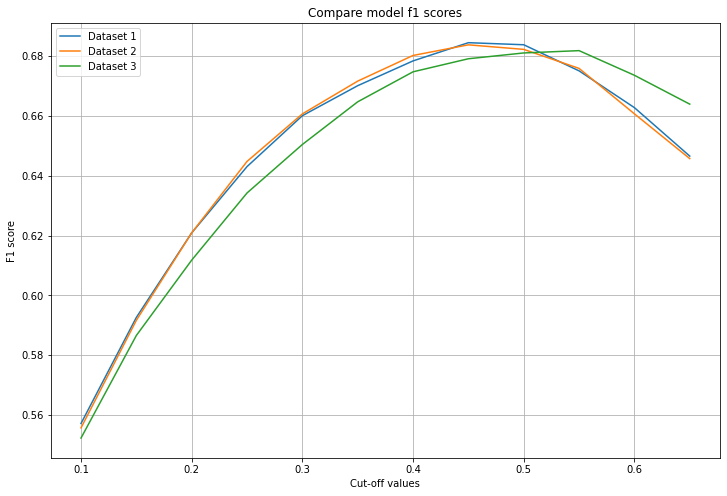

In [37]:
from matplotlib import pyplot as plt 
fig = plt.figure(figsize = (12, 8))

## Visualization of f1 metrics of each model
plt.plot(cut_off_values, avg_f1_score)
plt.plot(cut_off_values, avg_f1_score_lasso)
plt.plot(cut_off_values, avg_f1_score_extended)
plt.title('Compare model f1 scores')
plt.ylabel('F1 score')
plt.xlabel('Cut-off values')
plt.legend(['Dataset 1', 'Dataset 2', 'Dataset 3'], loc = 'upper left')
plt.grid()
plt.show()

In [38]:
## lists to store results
precision_scores = list()
recall_scores = list()
f1_scores = list()
lasso_precision_scores = list()
lasso_recall_scores = list()
lasso_f1_scores = list()

## Runing on cleaned data extended
extended_precision_scores = list()
extended_recall_scores = list()
extended_f1_scores = list()

kfold = StratifiedKFold(n_splits = 20, shuffle = True)
scaler = MinMaxScaler()

cut_off_values = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55]

for i in range(100):
    ## Running on cleaned data
    for train_ix, test_ix in kfold.split(X, Y):
        ## split data into train and validation folds
        X_train, X_test = X.loc[train_ix], X.loc[test_ix]
        X_train_lasso, X_test_lasso = X_lasso.loc[train_ix], X_lasso.loc[test_ix]
        Y_train, Y_test = Y.loc[train_ix], Y.loc[test_ix]

        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
        X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)
        X_train_lasso = pd.DataFrame(scaler.fit_transform(X_train_lasso), columns = X_train_lasso.columns)
        X_test_lasso = pd.DataFrame(scaler.fit_transform(X_test_lasso), columns = X_test_lasso.columns)

        ## build logistic models
        logit_md = LogisticRegression().fit(X_train, Y_train)
        logit_lasso_md = LogisticRegression().fit(X_train_lasso, Y_train)

        ## predict the likelihood
        pred = logit_md.predict_proba(X_test)[:,1]
        pred_lasso = logit_lasso_md.predict_proba(X_test_lasso)[:,1]

        precision = list()
        recall = list()
        f1s = list()
        lasso_precision = list()
        lasso_recall = list()
        lasso_f1 = list()
        for cut_off in cut_off_values:

            ## label likelihood
            pred_labels = np.where(pred < cut_off, 0, 1)
            pred_labels_lasso = np.where(pred_lasso < cut_off, 0, 1)

            ## compute and store score
            precision.append(precision_score(Y_test, pred_labels))
            recall.append(recall_score(Y_test, pred_labels, zero_division = 0))
            f1s.append(f1_score(Y_test, pred_labels, zero_division = 0))
            lasso_precision.append(precision_score(Y_test, pred_labels_lasso))
            lasso_recall.append(recall_score(Y_test, pred_labels_lasso, zero_division = 0))
            lasso_f1.append(f1_score(Y_test, pred_labels_lasso))

        ## compute and store score
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1s)
        lasso_precision_scores.append(lasso_precision)
        lasso_recall_scores.append(lasso_recall)
        lasso_f1_scores.append(lasso_f1)

    for train_ix, test_ix in kfold.split(X_lasso_extended, Y_lasso_extended):
        ## split data into train and validation folds
        X_train, X_test = X_lasso_extended.loc[train_ix], X_lasso_extended.loc[test_ix]
        Y_train, Y_test = Y_lasso_extended.loc[train_ix], Y_lasso_extended.loc[test_ix]

        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
        X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

        ## build logistic models
        logit_md = LogisticRegression().fit(X_train, Y_train)

        ## predict the likelihood
        pred = logit_md.predict_proba(X_test)[:,1]

        extended_precision = list()
        extended_recall = list()
        extended_f1 = list()
        for cut_off in cut_off_values:

            ## label likelihood
            pred_labels = np.where(pred < cut_off, 0, 1)

            extended_precision.append(precision_score(Y_test, pred_labels))
            extended_recall.append(recall_score(Y_test, pred_labels, zero_division = 0))
            extended_f1.append(f1_score(Y_test, pred_labels, zero_division = 0))


        ## compute and store score
        extended_precision_scores.append(extended_precision)
        extended_recall_scores.append(extended_recall)
        extended_f1_scores.append(extended_f1)

## compute average scores
avg_precision_score = np.mean(precision_scores, axis = 0)
avg_recall_score = np.mean(recall_scores, axis = 0)
avg_f1_score = np.mean(f1_scores, axis = 0)
avg_precision_score_lasso = np.mean(lasso_precision_scores, axis = 0)
avg_recall_score_lasso = np.mean(lasso_recall_scores, axis = 0)
avg_f1_score_lasso = np.mean(lasso_f1_scores, axis = 0)

## compute average scores
avg_precision_score_extended = np.mean(extended_precision_scores, axis = 0)
avg_recall_score_extended = np.mean(extended_recall_scores, axis = 0)
avg_f1_score_extended = np.mean(extended_f1_scores, axis = 0)



print('Cut-off values:', cut_off_values)
print('Logistic with all features')
print('Precision:', avg_precision_score)
print('Recall:   ', avg_recall_score)
print('F1 score: ', avg_f1_score)
print()
print('Logistic LASSO')
print('Precision:', avg_precision_score_lasso)
print('Recall:   ', avg_recall_score_lasso)
print('F1 score:', avg_f1_score_lasso)
print()
print('Logistic with extended data')
print('Precision:', avg_precision_score_extended)
print('Recall:   ', avg_recall_score_extended)
print('F1 score: ', avg_f1_score_extended)

Cut-off values: [0.3, 0.35, 0.4, 0.45, 0.5, 0.55]
Logistic with all features
Precision: [0.52212193 0.5474059  0.57183627 0.59468051 0.61885206 0.64010195]
Recall:    [0.91382143 0.8827381  0.84920238 0.81555952 0.7775     0.73397619]
F1 score:  [0.65928962 0.66927644 0.67589348 0.67936244 0.67914211 0.67237302]

Logistic LASSO
Precision: [0.52459484 0.55202966 0.57778639 0.60231191 0.62589935 0.64890278]
Recall:    [0.91296429 0.88146429 0.84854762 0.81333333 0.77063095 0.724     ]
F1 score: [0.66050511 0.67200699 0.67924941 0.68252016 0.67946064 0.67148078]

Logistic with extended data
Precision: [0.50788363 0.53502204 0.55986392 0.5824355  0.60344267 0.62479879]
Recall:    [0.93136111 0.90510417 0.8745625  0.841875   0.8049375  0.76547917]
F1 score:  [0.65263333 0.66705342 0.67620932 0.68125207 0.68158677 0.67870659]


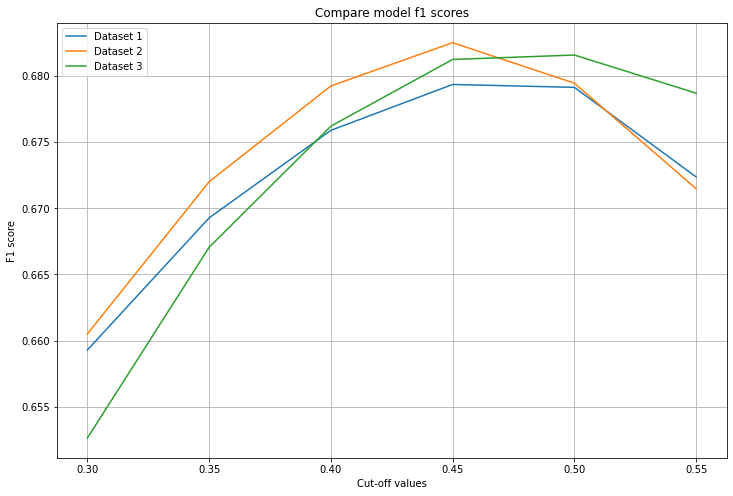

In [39]:
fig = plt.figure(figsize = (12, 8))

## Visualization of f1 metrics of each model
plt.plot(cut_off_values, avg_f1_score)
plt.plot(cut_off_values, avg_f1_score_lasso)
plt.plot(cut_off_values, avg_f1_score_extended)
plt.title('Compare model f1 scores')
plt.ylabel('F1 score')
plt.xlabel('Cut-off values')
plt.legend(['Dataset 1', 'Dataset 2', 'Dataset 3'], loc = 'upper left')
plt.grid()
plt.show()

In [40]:
## lists to store results
precision_scores = list()
recall_scores = list()
f1_scores = list()
lasso_precision_scores = list()
lasso_recall_scores = list()
lasso_f1_scores = list()

## Runing on cleaned data extended
extended_precision_scores = list()
extended_recall_scores = list()
extended_f1_scores = list()

kfold = StratifiedKFold(n_splits = 20, shuffle = True)
scaler = MinMaxScaler()

cut_off_values = [0.4, 0.45, 0.5]

for i in range(100):
    ## Running on cleaned data
    for train_ix, test_ix in kfold.split(X, Y):
        ## split data into train and validation folds
        X_train, X_test = X.loc[train_ix], X.loc[test_ix]
        X_train_lasso, X_test_lasso = X_lasso.loc[train_ix], X_lasso.loc[test_ix]
        Y_train, Y_test = Y.loc[train_ix], Y.loc[test_ix]

        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
        X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)
        X_train_lasso = pd.DataFrame(scaler.fit_transform(X_train_lasso), columns = X_train_lasso.columns)
        X_test_lasso = pd.DataFrame(scaler.fit_transform(X_test_lasso), columns = X_test_lasso.columns)

        ## build logistic models
        logit_md = LogisticRegression().fit(X_train, Y_train)
        logit_lasso_md = LogisticRegression().fit(X_train_lasso, Y_train)

        ## predict the likelihood
        pred = logit_md.predict_proba(X_test)[:,1]
        pred_lasso = logit_lasso_md.predict_proba(X_test_lasso)[:,1]

        precision = list()
        recall = list()
        f1s = list()
        lasso_precision = list()
        lasso_recall = list()
        lasso_f1 = list()
        for cut_off in cut_off_values:

            ## label likelihood
            pred_labels = np.where(pred < cut_off, 0, 1)
            pred_labels_lasso = np.where(pred_lasso < cut_off, 0, 1)

            ## compute and store score
            precision.append(precision_score(Y_test, pred_labels))
            recall.append(recall_score(Y_test, pred_labels, zero_division = 0))
            f1s.append(f1_score(Y_test, pred_labels, zero_division = 0))
            lasso_precision.append(precision_score(Y_test, pred_labels_lasso))
            lasso_recall.append(recall_score(Y_test, pred_labels_lasso, zero_division = 0))
            lasso_f1.append(f1_score(Y_test, pred_labels_lasso))

        ## compute and store score
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1s)
        lasso_precision_scores.append(lasso_precision)
        lasso_recall_scores.append(lasso_recall)
        lasso_f1_scores.append(lasso_f1)

    for train_ix, test_ix in kfold.split(X_lasso_extended, Y_lasso_extended):
        ## split data into train and validation folds
        X_train, X_test = X_lasso_extended.loc[train_ix], X_lasso_extended.loc[test_ix]
        Y_train, Y_test = Y_lasso_extended.loc[train_ix], Y_lasso_extended.loc[test_ix]

        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
        X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

        ## build logistic models
        logit_md = LogisticRegression().fit(X_train, Y_train)

        ## predict the likelihood
        pred = logit_md.predict_proba(X_test)[:,1]

        extended_precision = list()
        extended_recall = list()
        extended_f1 = list()
        for cut_off in cut_off_values:

            ## label likelihood
            pred_labels = np.where(pred < cut_off, 0, 1)

            extended_precision.append(precision_score(Y_test, pred_labels))
            extended_recall.append(recall_score(Y_test, pred_labels, zero_division = 0))
            extended_f1.append(f1_score(Y_test, pred_labels, zero_division = 0))


        ## compute and store score
        extended_precision_scores.append(extended_precision)
        extended_recall_scores.append(extended_recall)
        extended_f1_scores.append(extended_f1)

## compute average scores
avg_precision_score = np.mean(precision_scores, axis = 0)
avg_recall_score = np.mean(recall_scores, axis = 0)
avg_f1_score = np.mean(f1_scores, axis = 0)
avg_precision_score_lasso = np.mean(lasso_precision_scores, axis = 0)
avg_recall_score_lasso = np.mean(lasso_recall_scores, axis = 0)
avg_f1_score_lasso = np.mean(lasso_f1_scores, axis = 0)

## compute average scores
avg_precision_score_extended = np.mean(extended_precision_scores, axis = 0)
avg_recall_score_extended = np.mean(extended_recall_scores, axis = 0)
avg_f1_score_extended = np.mean(extended_f1_scores, axis = 0)



print('Cut-off values:', cut_off_values)
print('Logistic with all features')
print('Precision:', avg_precision_score)
print('Recall:   ', avg_recall_score)
print('F1 score: ', avg_f1_score)
print()
print('Logistic LASSO')
print('Precision:', avg_precision_score_lasso)
print('Recall:   ', avg_recall_score_lasso)
print('F1 score:', avg_f1_score_lasso)
print()
print('Logistic with extended data')
print('Precision:', avg_precision_score_extended)
print('Recall:   ', avg_recall_score_extended)
print('F1 score: ', avg_f1_score_extended)

Cut-off values: [0.4, 0.45, 0.5]
Logistic with all features
Precision: [0.57490383 0.59834398 0.61895635]
Recall:    [0.85335714 0.81607143 0.77633333]
F1 score:  [0.67935323 0.6818223  0.67889257]

Logistic LASSO
Precision: [0.57917302 0.60265432 0.6236407 ]
Recall:    [0.85121429 0.81189286 0.76895238]
F1 score: [0.68120237 0.68223288 0.67791267]

Logistic with extended data
Precision: [0.55896535 0.58152431 0.60405331]
Recall:    [0.87161111 0.83849306 0.80317361]
F1 score:  [0.67437405 0.6790008  0.68084212]


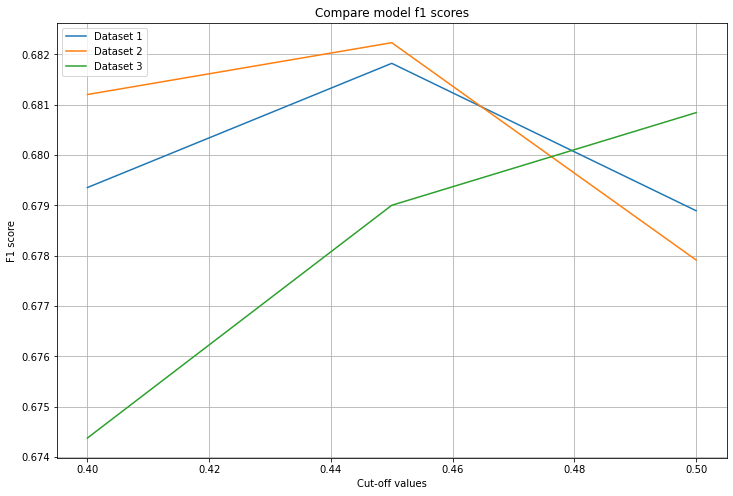

In [41]:
fig = plt.figure(figsize = (12, 8))

## Visualization of f1 metrics of each model
plt.plot(cut_off_values, avg_f1_score)
plt.plot(cut_off_values, avg_f1_score_lasso)
plt.plot(cut_off_values, avg_f1_score_extended)
plt.title('Compare model f1 scores')
plt.ylabel('F1 score')
plt.xlabel('Cut-off values')
plt.legend(['Dataset 1', 'Dataset 2', 'Dataset 3'], loc = 'upper left')
plt.grid()
plt.show()

In [ ]:
cut_off = 0.45

## lists to store results
precision_scores = list()
recall_scores = list()
f1_scores = list()
lasso_precision_scores = list()
lasso_recall_scores = list()
lasso_f1_scores = list()

## Runing on cleaned data extended
extended_precision_scores = list()
extended_recall_scores = list()
extended_f1_scores = list()

kfold = StratifiedKFold(n_splits = 20, shuffle = True)
scaler = MinMaxScaler()

for i in range(100):
    ## Running on cleaned data
    for train_ix, test_ix in kfold.split(X, Y):
        ## split data into train and validation folds
        X_train, X_test = X.loc[train_ix], X.loc[test_ix]
        X_train_lasso, X_test_lasso = X_lasso.loc[train_ix], X_lasso.loc[test_ix]
        Y_train, Y_test = Y.loc[train_ix], Y.loc[test_ix]

        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
        X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)
        X_train_lasso = pd.DataFrame(scaler.fit_transform(X_train_lasso), columns = X_train_lasso.columns)
        X_test_lasso = pd.DataFrame(scaler.fit_transform(X_test_lasso), columns = X_test_lasso.columns)

        ## build logistic models
        logit_md = LogisticRegression().fit(X_train, Y_train)
        logit_lasso_md = LogisticRegression().fit(X_train_lasso, Y_train)

        ## predict the likelihood
        pred = logit_md.predict_proba(X_test)[:,1]
        pred_lasso = logit_lasso_md.predict_proba(X_test_lasso)[:,1]

        ## label likelihood
        pred_labels = np.where(pred < cut_off, 0, 1)
        pred_labels_lasso = np.where(pred_lasso < cut_off, 0, 1)

        ## compute and store score
        precision_scores.append(precision_score(Y_test, pred_labels))
        recall_scores.append(recall_score(Y_test, pred_labels, zero_division = 0))
        f1_scores.append(f1_score(Y_test, pred_labels, zero_division = 0))
        lasso_precision_scores.append(precision_score(Y_test, pred_labels_lasso))
        lasso_recall_scores.append(recall_score(Y_test, pred_labels_lasso, zero_division = 0))
        lasso_f1_scores.append(f1_score(Y_test, pred_labels_lasso))

    for train_ix, test_ix in kfold.split(X_lasso_extended, Y_lasso_extended):
        ## split data into train and validation folds
        X_train, X_test = X_lasso_extended.loc[train_ix], X_lasso_extended.loc[test_ix]
        Y_train, Y_test = Y_lasso_extended.loc[train_ix], Y_lasso_extended.loc[test_ix]

        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
        X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

        ## build logistic models
        logit_md = LogisticRegression().fit(X_train, Y_train)

        ## predict the likelihood
        pred = logit_md.predict_proba(X_test)[:,1]

        ## label likelihood
        pred_labels = np.where(pred < cut_off, 0, 1)

        ## compute and store score
        extended_precision_scores.append(precision_score(Y_test, pred_labels))
        extended_recall_scores.append(recall_score(Y_test, pred_labels, zero_division = 0))
        extended_f1_scores.append(f1_score(Y_test, pred_labels, zero_division = 0))

## compute average scores
avg_precision_score = np.mean(precision_scores, axis = 0)
avg_recall_score = np.mean(recall_scores, axis = 0)
avg_f1_score = np.mean(f1_scores, axis = 0)
avg_precision_score_lasso = np.mean(lasso_precision_scores, axis = 0)
avg_recall_score_lasso = np.mean(lasso_recall_scores, axis = 0)
avg_f1_score_lasso = np.mean(lasso_f1_scores, axis = 0)

## compute average scores
avg_precision_score_extended = np.mean(extended_precision_scores, axis = 0)
avg_recall_score_extended = np.mean(extended_recall_scores, axis = 0)
avg_f1_score_extended = np.mean(extended_f1_scores, axis = 0)

In [ ]:
print('Cut-off values:', cut_off)
print('Logistic with all features')
print('Precision:', avg_precision_score)
print('Recall:   ', avg_recall_score)
print('F1 score: ', avg_f1_score)
print()
print('Logistic LASSO')
print('Precision:', avg_precision_score_lasso)
print('Recall:   ', avg_recall_score_lasso)
print('F1 score:', avg_f1_score_lasso)
print()
print('Logistic with extended data')
print('Precision:', avg_precision_score_extended)
print('Recall:   ', avg_recall_score_extended)
print('F1 score: ', avg_f1_score_extended)

## Logistic Regression look good with cleaned dataset and cut off value of 0.45, both with full number and reduced number of features using LASSO 